In [ ]:
#@title Run this cell to create the database and make query function

import sqlite3
con = sqlite3.connect('ClimberInfo.db')

import pandas as pd
from sklearn.datasets import make_blobs
import numpy as np
from numpy.random import default_rng

def query(sql_query_str, connection=con):
  df = None
  try:
    df = pd.read_sql_query(sql_query_str, connection).drop('index', axis=1)
  except:
    df = pd.read_sql_query(sql_query_str, connection)
  
  if len(df) <= 200:
    return df
  else:
    print('Pandas Memory Error: File is too big to keep in RAM!')
    raise

def save_query_to_csv(sql_query_str, output_file_name, connection=con):
  df = None
  try:
    df = pd.read_sql_query(sql_query_str, connection).drop('index', axis=1)
  except:
    df = pd.read_sql_query(sql_query_str, connection)

  df.to_csv(output_file_name)
  return output_file_name

def create_database():
  cluster_centers = np.array([ [25, 60], [25, 95], [50, 75], [50, 100], [40, 60], [35, 80]])
  blobs, labels = make_blobs(n_samples=200, n_features=2, centers=cluster_centers, cluster_std=[3, 3, 3, 3, 3, 3])
  blobs_as_dataframe = pd.DataFrame(data=blobs, columns=['Age', 'Weight'])
  ages = blobs_as_dataframe['Age']
  weights = blobs_as_dataframe['Weight']
  ages = ages.apply(lambda x: int(x))
  weights = weights.apply(lambda x: int(x))
  data = pd.DataFrame(data=np.array([ages, weights]).T, columns=['Age (Years)', 'Weight (kg)'])
  data['ID'] = data.index
  data_in = data[['ID', 'Age (Years)', 'Weight (kg)']]
  rng = default_rng()
  age_df = data_in[['ID', 'Age (Years)']]
  weight_df = data_in[['ID', 'Weight (kg)']]

  def create_noisey_weight_df(weight_df=weight_df):
    another_series = weight_df.apply(lambda row: str(row['ID']) + " " + str(row['Weight (kg)'] + rng.standard_normal() + rng.standard_normal()), axis=1)
    np_arr = another_series.to_numpy()
    good_arr = [x.split(' ') for x in np_arr]
    good_arr = [[int(a), float(b)] for a, b in good_arr]
    return pd.DataFrame(data=good_arr, columns=['ID', 'Weight (kg)'])
  
  hundred_noisey_weight_dfs = [create_noisey_weight_df() for i in range(100)]
  all_weights = pd.concat(hundred_noisey_weight_dfs)
  ages_to_keep, weights_to_keep = age_df, all_weights
  ages_to_keep.to_sql(name='Ages', con=con)
  weights_to_keep.to_sql(name='Weights', con=con)

create_database()
cursor = con.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('Ages',), ('Weights',)]


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [ ]:
query('select * from Ages')

,ID,Age (Years)
0,0,30
1,1,46
2,2,53
3,3,38
4,4,38
...,...,...
195,195,34
196,196,38
197,197,24
198,198,45


In [ ]:
query('select * from Weights')

Pandas Memory Error: File is too big to keep in RAM!


RuntimeError: ignored

In [ ]:
save_query_to_csv('select * from Weights', 'raw_weights.csv')

'raw_weights.csv'

In [ ]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark
!wget -q https://student.cs.uwaterloo.ca/~cs451/content/cs431/p2p-Gnutella08-adj.txt
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf

spark_conf = SparkConf()\
  .setAppName("YourTest")\
  .setMaster("local[*]")

sc = SparkContext.getOrCreate(spark_conf)

def read_csv_into_spark_rdd(f):
  spark_df = sc.textFile(f)
  return spark_df.map(lambda x: (x.split(',')[1:]))

In [ ]:
raw_rdd = read_csv_into_spark_rdd('raw_weights.csv')
raw_rdd.take(10)

[['ID', 'Weight (kg)'],
 ['0', '80.43735176201794'],
 ['1', '74.22728788041981'],
 ['2', '71.47180426256175'],
 ['3', '81.32517954653619'],
 ['4', '85.55033289067049'],
 ['5', '59.91303310543387'],
 ['6', '56.055726880037504'],
 ['7', '76.59314442764592'],
 ['8', '91.45500670211806']]

In [ ]:
raw_rdd.count()

20001

In [ ]:
data = raw_rdd.filter(lambda x: x[0] != 'ID').map(lambda x: (int(x[0]), float(x[1])))
data.take(5)

[(0, 80.43735176201794),
 (1, 74.22728788041981),
 (2, 71.47180426256175),
 (3, 81.32517954653619),
 (4, 85.55033289067049)]

In [ ]:
grouped_by_id = data.groupByKey()
grouped_by_id.take(5)

[(0, <pyspark.resultiterable.ResultIterable at 0x7fa594ada190>),
 (2, <pyspark.resultiterable.ResultIterable at 0x7fa594ada1d0>),
 (4, <pyspark.resultiterable.ResultIterable at 0x7fa595502ed0>),
 (6, <pyspark.resultiterable.ResultIterable at 0x7fa594ada410>),
 (8, <pyspark.resultiterable.ResultIterable at 0x7fa595502f10>)]

In [ ]:
viewable_grouped = grouped_by_id.map(lambda x: (x[0], list(x[1])))
viewable_grouped.take(2)

[(0,
  [80.43735176201794,
   80.45146854119449,
   80.91209251379784,
   81.16134847142908,
   81.84457707308832,
   81.09441146552189,
   80.1696918512258,
   82.66737691296701,
   83.21679508435217,
   79.76440311221245,
   81.88312274415642,
   80.13010811167929,
   78.60462569454778,
   80.06296466760546,
   78.62484993899139,
   81.27457592007322,
   83.67900281488419,
   83.40212568228037,
   82.67288236833006,
   79.80945066411267,
   81.06260039237243,
   80.07092212596724,
   82.97827504457807,
   81.07406926310485,
   83.52608302218995,
   80.66902134384867,
   81.52821878300324,
   79.97374828401384,
   80.97830769165837,
   78.87433962612978,
   82.01126960760344,
   80.79180265506677,
   81.83552436190456,
   81.45411224888632,
   79.4944923546717,
   80.01427379672039,
   80.56246610061378,
   81.8828763840372,
   81.98007794077509,
   77.16257423557997,
   82.12040909634082,
   80.57726582154282,
   80.90478329856764,
   79.56795031759474,
   84.79888481427886,
   82.38

In [ ]:
averaged = viewable_grouped.map(lambda x: (x[0], sum(x[1]) / len(x[1])))
averaged.take(5)

[(0, 80.96774042546423),
 (2, 73.0423281944838),
 (4, 86.1403250782955),
 (6, 56.101471547062836),
 (8, 92.94716913436018)]

In [ ]:
weights_rdd = averaged

In [ ]:
save_query_to_csv('select * from Ages', 'raw_ages.csv')

'raw_ages.csv'

In [ ]:
ages_rdd = read_csv_into_spark_rdd('raw_ages.csv')
ages_rdd.take(5)

[['ID', 'Age (Years)'], ['0', '30'], ['1', '46'], ['2', '53'], ['3', '38']]

In [ ]:
ages_rdd = ages_rdd.map(lambda x: (int(x[0]), int(x[1])))
ages_rdd.take(2)

[(0, 30), (1, 46)]

In [ ]:
id_age_weight_rdd = ages_rdd.join(weights_rdd).map(lambda x: (x[0], x[1][0], x[1][1]))
id_age_weight_rdd.take(5)

[(0, 30, 80.96774042546423),
 (4, 38, 86.1403250782955),
 (8, 24, 92.94716913436018),
 (12, 38, 57.91490202298724),
 (16, 21, 98.71378583429981)]

In [ ]:
collected = id_age_weight_rdd.collect()
collected

[(0, 30, 80.96774042546423),
 (4, 38, 86.1403250782955),
 (8, 24, 92.94716913436018),
 (12, 38, 57.91490202298724),
 (16, 21, 98.71378583429981),
 (20, 54, 74.06924783050584),
 (24, 34, 76.98119002371654),
 (28, 53, 96.90043196720443),
 (32, 25, 57.78462298661646),
 (36, 47, 99.169056568121),
 (40, 27, 61.24373737801336),
 (44, 27, 57.98875040659707),
 (48, 49, 100.3596689503204),
 (52, 27, 92.9457405436614),
 (56, 22, 63.90274614523731),
 (60, 26, 94.0955547597287),
 (64, 51, 101.1974331843871),
 (68, 28, 91.20361101007187),
 (72, 39, 60.13427973978754),
 (76, 45, 70.08939903541653),
 (80, 50, 98.9964462930701),
 (84, 39, 53.75465457904492),
 (88, 44, 60.05128953563963),
 (92, 26, 60.75510263887392),
 (96, 51, 95.94225114475728),
 (100, 22, 62.88998935584889),
 (104, 38, 77.23580855886028),
 (108, 45, 97.90564002515458),
 (112, 28, 86.94793684329812),
 (116, 53, 73.14579750617649),
 (120, 51, 74.97378537431224),
 (124, 47, 72.89992256886202),
 (128, 43, 75.94920648803092),
 (132, 38, 

In [ ]:
good_pd_df = pd.DataFrame(collected, columns=['ID', 'Age_in_years', 'Weight_in_kg'])
good_pd_df

,ID,Age_in_years,Weight_in_kg
0,0,30,80.967740
1,4,38,86.140325
2,8,24,92.947169
3,12,38,57.914902
4,16,21,98.713786
...,...,...,...
195,183,40,60.866852
196,187,23,60.950758
197,191,37,54.779462
198,195,34,76.041813


In [ ]:
good_pd_df.to_pickle('id_age_weight_combined.pkl')

In [ ]:
good_pd_df = pd.read_pickle('id_age_weight_combined.pkl')
good_pd_df

,ID,Age_in_years,Weight_in_kg
0,0,30,80.967740
1,4,38,86.140325
2,8,24,92.947169
3,12,38,57.914902
4,16,21,98.713786
...,...,...,...
195,183,40,60.866852
196,187,23,60.950758
197,191,37,54.779462
198,195,34,76.041813


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa594a28d10>,
      dtype=object)

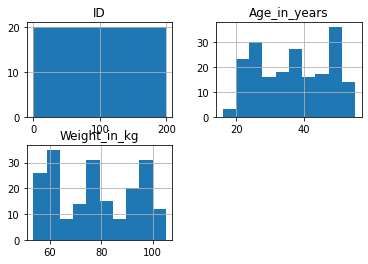

In [ ]:
good_pd_df.hist()

In [ ]:
good_pd_df.describe()

,ID,Age_in_years,Weight_in_kg
count,200.000000,200.000000,200.000000
mean,99.500000,36.815000,77.759906
std,57.879185,10.610073,15.383013
min,0.000000,16.000000,53.754655
25%,49.750000,27.000000,61.970161
50%,99.500000,37.000000,77.075806
75%,149.250000,47.250000,93.035722
max,199.000000,55.000000,105.052305


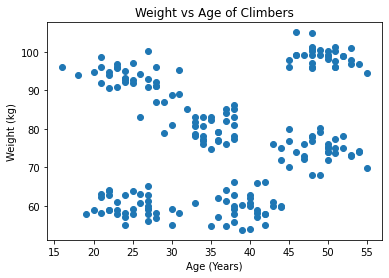

In [ ]:
import matplotlib.pyplot as plt

ages = good_pd_df['Age_in_years']
weights = good_pd_df['Weight_in_kg']
plt.scatter(ages, weights)
plt.xlabel('Age (Years)')
plt.ylabel('Weight (kg)')
plt.title('Weight vs Age of Climbers')
plt.show()

In [ ]:
prepared_data = np.array([ages, weights]).T
prepared_data

array([[ 30.        ,  80.96774043],
       [ 38.        ,  86.14032508],
       [ 24.        ,  92.94716913],
       [ 38.        ,  57.91490202],
       [ 21.        ,  98.71378583],
       [ 54.        ,  74.06924783],
       [ 34.        ,  76.98119002],
       [ 53.        ,  96.90043197],
       [ 25.        ,  57.78462299],
       [ 47.        ,  99.16905657],
       [ 27.        ,  61.24373738],
       [ 27.        ,  57.98875041],
       [ 49.        , 100.35966895],
       [ 27.        ,  92.94574054],
       [ 22.        ,  63.90274615],
       [ 26.        ,  94.09555476],
       [ 51.        , 101.19743318],
       [ 28.        ,  91.20361101],
       [ 39.        ,  60.13427974],
       [ 45.        ,  70.08939904],
       [ 50.        ,  98.99644629],
       [ 39.        ,  53.75465458],
       [ 44.        ,  60.05128954],
       [ 26.        ,  60.75510264],
       [ 51.        ,  95.94225114],
       [ 22.        ,  62.88998936],
       [ 38.        ,  77.23580856],
 

In [ ]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=6)
kmeans_model.fit(prepared_data)
cluster_centers = kmeans_model.cluster_centers_
cluster_centers

array([[49.45454545, 98.92185882],
       [39.46875   , 59.61751238],
       [24.64705882, 93.33225611],
       [49.03030303, 74.62064723],
       [24.77142857, 59.80652026],
       [34.6969697 , 80.32706328]])

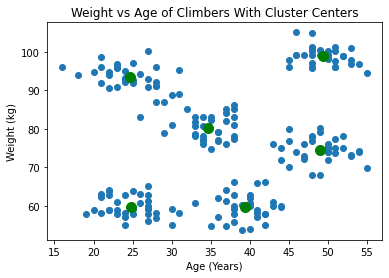

In [ ]:
ages = good_pd_df['Age_in_years']
weights = good_pd_df['Weight_in_kg']
plt.scatter(ages, weights)
plt.xlabel('Age (Years)')
plt.ylabel('Weight (kg)')
plt.title('Weight vs Age of Climbers With Cluster Centers')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='green', s=100)
plt.show()

In [ ]:
labels = kmeans_model.labels_
labels

array([5, 5, 2, 1, 2, 3, 5, 0, 4, 0, 4, 4, 0, 2, 4, 2, 0, 2, 1, 3, 0, 1,
       1, 4, 0, 4, 5, 0, 2, 3, 3, 3, 3, 1, 3, 3, 3, 3, 5, 0, 5, 3, 1, 0,
       5, 4, 1, 3, 1, 1, 3, 4, 2, 4, 4, 4, 5, 4, 5, 1, 2, 4, 0, 2, 3, 4,
       3, 4, 3, 2, 4, 2, 2, 3, 0, 0, 1, 2, 0, 4, 3, 4, 4, 4, 3, 0, 5, 2,
       1, 1, 5, 2, 4, 5, 0, 1, 2, 3, 0, 2, 3, 4, 2, 0, 5, 5, 5, 1, 4, 0,
       2, 1, 5, 0, 1, 5, 2, 2, 1, 3, 0, 2, 0, 5, 4, 0, 2, 4, 3, 3, 4, 0,
       1, 5, 2, 4, 2, 2, 5, 5, 5, 4, 0, 0, 1, 5, 3, 2, 4, 0, 5, 5, 2, 4,
       0, 3, 0, 4, 5, 1, 3, 1, 0, 2, 3, 1, 1, 0, 0, 3, 1, 3, 2, 2, 0, 5,
       3, 1, 4, 1, 4, 0, 3, 5, 5, 2, 1, 2, 5, 1, 5, 4, 5, 2, 3, 1, 4, 1,
       5, 1], dtype=int32)

In [ ]:
final_pd_df = good_pd_df
final_pd_df['Cluster'] = pd.Series(labels)
final_pd_df

,ID,Age_in_years,Weight_in_kg,Cluster
0,0,30,80.967740,5
1,4,38,86.140325,5
2,8,24,92.947169,2
3,12,38,57.914902,1
4,16,21,98.713786,2
...,...,...,...,...
195,183,40,60.866852,1
196,187,23,60.950758,4
197,191,37,54.779462,1
198,195,34,76.041813,5


In [ ]:
final_as_np = final_pd_df.to_numpy()
final_as_np

array([[  0.        ,  30.        ,  80.96774043,   5.        ],
       [  4.        ,  38.        ,  86.14032508,   5.        ],
       [  8.        ,  24.        ,  92.94716913,   2.        ],
       [ 12.        ,  38.        ,  57.91490202,   1.        ],
       [ 16.        ,  21.        ,  98.71378583,   2.        ],
       [ 20.        ,  54.        ,  74.06924783,   3.        ],
       [ 24.        ,  34.        ,  76.98119002,   5.        ],
       [ 28.        ,  53.        ,  96.90043197,   0.        ],
       [ 32.        ,  25.        ,  57.78462299,   4.        ],
       [ 36.        ,  47.        ,  99.16905657,   0.        ],
       [ 40.        ,  27.        ,  61.24373738,   4.        ],
       [ 44.        ,  27.        ,  57.98875041,   4.        ],
       [ 48.        ,  49.        , 100.35966895,   0.        ],
       [ 52.        ,  27.        ,  92.94574054,   2.        ],
       [ 56.        ,  22.        ,  63.90274615,   4.        ],
       [ 60.        ,  26

In [ ]:
from math import sin

def best_climb(age, weight):
  return (abs(sin(age))*5 + abs(sin(weight))*7) % 10

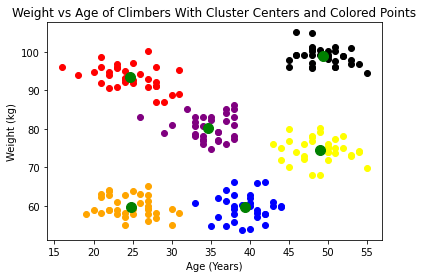

In [ ]:
colors = ['black', 'blue', 'red', 'yellow', 'orange', 'purple']

for row in final_as_np:
  x = row[1]
  y = row[2]
  label = row[3]
  color = colors[int(label)]
  plt.scatter(x, y, color=color)

plt.xlabel('Age (Years)')
plt.ylabel('Weight (kg)')
plt.title('Weight vs Age of Climbers With Cluster Centers and Colored Points')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='green', s=100)
plt.show()

In [ ]:
climb_difficulties = [best_climb(x, y) for x, y in cluster_centers]
climb_difficulties

[0.6195284858999024,
 5.410267307170974,
 7.884231709947503,
 9.631917541077225,
 2.579499030042442,
 7.531656056975114]

In [ ]:
correct_climbs = final_pd_df['Cluster'].apply(lambda x: climb_difficulties[x])
correct_climbs

0      7.531656
1      7.531656
2      7.884232
3      5.410267
4      7.884232
         ...   
195    5.410267
196    2.579499
197    5.410267
198    7.531656
199    5.410267
Name: Cluster, Length: 200, dtype: float64

In [ ]:
final_pd_df['Best Climb'] = correct_climbs
final_pd_df

,ID,Age_in_years,Weight_in_kg,Cluster,Best Climb
0,0,30,80.967740,5,7.531656
1,4,38,86.140325,5,7.531656
2,8,24,92.947169,2,7.884232
3,12,38,57.914902,1,5.410267
4,16,21,98.713786,2,7.884232
...,...,...,...,...,...
195,183,40,60.866852,1,5.410267
196,187,23,60.950758,4,2.579499
197,191,37,54.779462,1,5.410267
198,195,34,76.041813,5,7.531656


In [ ]:
def best_climb_given_id(id, df=final_pd_df):
  return df[df['ID'] == id]['Best Climb']

In [ ]:
best_climb_given_id(4)

1    7.531656
Name: Best Climb, dtype: float64